In [1]:
import sys
import os
sys.path.append(os.path.abspath(sys.path[0] + '/../'))

import torch
import matplotlib.pyplot as plt
import numpy as np
from utils import img
from utils import sphere
from utils.constants import *
from nets.msl_net import *

# Select device
torch.cuda.set_device(2)
print("Set CUDA:%d as current device." % torch.cuda.current_device())


Set CUDA:2 as current device.


# Test Ray-Sphere Intersection & Cartesian-Spherical Conversion

tensor([[ 0.0000, -0.3536,  0.3536]])
tensor(0.5000)
tensor([[ 90., 135.]])
torch.Size([1, 3])


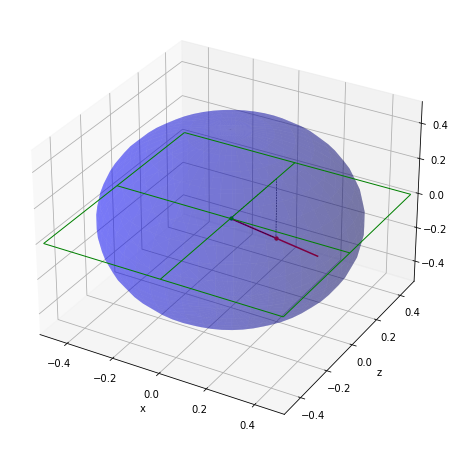

In [9]:
def PlotSphere(ax, r):
    u, v = np.mgrid[0:2 * PI:50j, 0:PI:20j]
    x = np.cos(u) * np.sin(v) * r
    y = np.sin(u) * np.sin(v) * r
    z = np.cos(v) * r
    ax.plot_surface(x, y, z, rstride=1, cstride=1,
                    color='b', linewidth=0.5, alpha=0.3)


def PlotPlane(ax, r):
    # 二元函数定义域平面
    x = np.linspace(-r, r, 3)
    y = np.linspace(-r, r, 3)
    X, Y = np.meshgrid(x, y)
    ax.plot_wireframe(X, Y, X * 0, color='g', linewidth=1)


p = torch.tensor([[0.0, 0.0, 0.0]])
v = torch.tensor([[0.0, -1.0, 1.0]])
r = torch.tensor([[0.5]])
v = v / torch.norm(v) * r * 2
p_on_sphere_ = sphere.ray_sphere_intersect(p, v, r)[0][0]
print(p_on_sphere_)
print(p_on_sphere_.norm())
spher_coord = sphere.cartesian2spherical(p_on_sphere_)
print(spher_coord[..., 1:3].rad2deg())
p_on_sphere = sphere.spherical2cartesian(spher_coord)
print(p_on_sphere_.size())

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
plt.xlabel('x')
plt.ylabel('z')

PlotPlane(ax, r.item())
PlotSphere(ax, r[0, 0].item())

ax.scatter([0], [0], [0], color="g", s=10)  # Center
ax.scatter([p_on_sphere[0, 0].item()],
           [p_on_sphere[0, 2].item()],
           [p_on_sphere[0, 1].item()],
           color="r", s=10)  # Ray position
ax.scatter([p_on_sphere_[0, 0].item()],
           [p_on_sphere_[0, 2].item()],
           [p_on_sphere_[0, 1].item()],
           color="y", s=10)  # Ray position

p_ = p + v
ax.plot([p[0, 0].item(), p_[0, 0].item()],
        [p[0, 2].item(), p_[0, 2].item()],
        [p[0, 1].item(), p_[0, 1].item()],
        color="r")

ax.plot([p_on_sphere_[0, 0].item(), p_on_sphere_[0, 0].item()],
        [p_on_sphere_[0, 2].item(), p_on_sphere_[0, 2].item()],
        [0, p_on_sphere_[0, 1].item()], color="k", linestyle='--', linewidth=0.5)

ax.plot([p_on_sphere_[0, 0].item(), 0],
        [p_on_sphere_[0, 2].item(), 0],
        [0, 0],
        linewidth=0.5, linestyle="--", color="k")

ax.plot([p_on_sphere_[0, 0].item(), 0],
        [p_on_sphere_[0, 2].item(), 0],
        [p_on_sphere_[0, 1], 0],
        linewidth=0.5, linestyle="--", color="k")

ax.set_xlim(-r.item(), r.item())
ax.set_ylim(-r.item(), r.item())
ax.set_zlim(-r.item(), r.item())

plt.show()


# Test Dataset Loader

In [2]:
from data.spherical_view_syn import SphericalViewSynDataset
from data.loader import FastDataLoader

DATA_DESC_FILE = '../data/classroom/r360x120_t0.5x0.5x0.5/train_1.json'

dataset = SphericalViewSynDataset(DATA_DESC_FILE, calculate_rays=False)
#dataset.set_patch_size((64, 64))
data_loader = FastDataLoader(dataset, 4, shuffle=False)
#print(len(dataset))
#print(dataset.view_rots)

fig = plt.figure(figsize=(12, 6.5))
i = 0
for indices, patches, rays_o, rays_d in data_loader:
    print(i, patches.size(), rays_o.size(), rays_d.size())
    for idx in range(len(indices)):
        plt.subplot(4, 7, i + 1)
        img.plot(patches[idx])
        i += 1
    if i == 4:
        break


Convert from OGL coordinate to DX coordinate (i. e. flip z axis)


AttributeError: 'SphericalViewSynDataset' object has no attribute 'patched_rays_o'

<Figure size 864x468 with 0 Axes>

# Validate Dataset

In [ ]:
from data.spherical_view_syn import SphericalViewSynDataset
from data.loader import FastDataLoader


DATA_DIR = '../data/pabellon_fovea_r40x40_t0.3'
#DATA_DIR = '../data/gas_fovea_r80x60_t0.3_2021.01.26'
#DATA_DIR = '../data/nerf_fern'
#DATA_DIR = '../data/lobby_fovea_2021.01.18'
TRAIN_DATA_DESC_FILE = DATA_DIR + '/train.json'


dataset = SphericalViewSynDataset(TRAIN_DATA_DESC_FILE)
dataset.set_patch_size(1)
res = dataset.view_res
data_loader = FastDataLoader(dataset, res[0] * res[1], shuffle=True)

selector = torch.arange(res[0] * res[1]).reshape(res[0], res[1])[::3, ::3].flatten()

for ri in range(0, 9):
    r = ri * 2 + 5
    p = None
    centers = None
    pixels = None
    idx_range = [0, 9]
    idx = 0
    for indices, patches, rays_o, rays_d in data_loader:
        idx += 1
        if idx <= idx_range[0]:
            continue
        patches = patches[selector]
        rays_o = rays_o[selector]
        rays_d = rays_d[selector]
        r = torch.tensor([[r]], device=device.default())
        p_ = misc.torch2np(sphere.ray_sphere_intersect(rays_o, rays_d, r)[0].view(-1, 3))
        p = p_ if p is None else np.concatenate((p, p_), axis=0)
        pixels_ = misc.torch2np(patches)
        pixels = pixels_ if pixels is None else np.concatenate((pixels, pixels_), axis=0)
        if idx >= idx_range[1]:
            break

    if ri % 2 == 0:
        plt.figure(facecolor='white', figsize=(20, 10))
    ax = plt.subplot(1, 2, ri % 2 + 1, projection='3d')
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('r = %f' % r)
    ax.scatter([0], [0], [0], color="k", s=10)
    ax.scatter(p[:, 0], p[:, 2], p[:, 1], color=pixels, s=0.5)
    ax.view_init(elev=0, azim=-90)
